In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
#importing the layers
from tensorflow.keras.layers import Conv2D,Flatten, Activation, Dense, BatchNormalization,GlobalAveragePooling2D,Concatenate,Add
# pretrained function for resnet-50
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#image datagen for labelling the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import numpy as np
#from keras.optimizers import adam
import matplotlib.pyplot as plt

In [124]:
#import tensorflow_datasets as tfds
# from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf
import pathlib
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [125]:
train_B = tf.data.Dataset.list_files("/content/drive/MyDrive/majorproject/gan_datasets/train_B/*.jpg")
test_B = tf.data.Dataset.list_files("/content/drive/MyDrive/majorproject/gan_datasets/test_B/*.jpg")

In [126]:
train_A = tf.data.Dataset.list_files("/content/drive/MyDrive/majorproject/gan_datasets/train_A/*.jpg")
test_A = tf.data.Dataset.list_files("/content/drive/MyDrive/majorproject/gan_datasets/test_A/*.jpg")

In [127]:
print(type(train_A))
print(train_A)

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>
<ShuffleDataset shapes: (), types: tf.string>


In [128]:
BUFFER_SIZE = 1000
BATCH_SIZE = 48
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
BATCH_SIZE1= 1

In [129]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [130]:
def resize(input_image):
  input_image = tf.image.resize(input_image, [256,256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image

In [131]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  image = tf.cast(image, tf.float32)

  return image

In [132]:
def preprocess_image_train(image):
  image=load(image)
  #image = random_jitter(image)
  image=resize(image)
  image = normalize(image)
  return image

In [133]:
def preprocess_image_test(image):
  image=load(image)
  image=resize(image)
  image = normalize(image)
  return image

In [134]:
train_A = train_A.map(preprocess_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_A = train_A.shuffle(BUFFER_SIZE)
train_A = train_A.batch(BATCH_SIZE)

In [135]:
train_B = train_B.map(preprocess_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_B = train_B.shuffle(BUFFER_SIZE)
train_B = train_B.batch(BATCH_SIZE)

In [136]:
test_A = test_A.map(preprocess_image_test)
test_A = test_A.batch(BATCH_SIZE1)

In [137]:
test_B = test_B.map(preprocess_image_test)
test_B = test_B.batch(BATCH_SIZE1)

In [138]:
type(test_B)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [139]:
data_A = next(iter(train_A))
data_B = next(iter(train_B))

In [140]:
len(train_B)

6

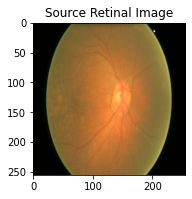

In [141]:
plt.subplot(121)                    
plt.title('Source Retinal Image')   
plt.imshow(data_A[0] * 0.5 + 0.5)  

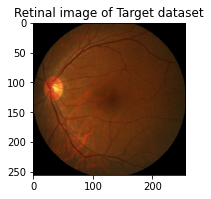

In [142]:
plt.subplot(121)
plt.title('Retinal image of Target dataset')
plt.imshow(data_B[0] * 0.5 + 0.5)

In [143]:

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [144]:
print(tf.expand_dims(data_A[0], 0).shape)
down_model = downsample(512, 4)
down_result = down_model(tf.expand_dims(data_A[0], 0))
print (down_result.shape)

(1, 256, 256, 3)
(1, 128, 128, 512)


In [145]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [146]:
up_model = upsample(36, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 36)


In [147]:
g = Conv2D(512, (4,4),strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(down_result)
print(g.shape)
g = Conv2D(512, (4,4),strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(g)
print(g.shape)
g=Add()([g,down_result])
g.shape

(1, 128, 128, 512)
(1, 128, 128, 512)


TensorShape([1, 128, 128, 512])

In [148]:
def Residual(n_filters, input_layer):
	# weight initialization
    init = tf.random_normal_initializer(0., 0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3),strides=1, padding='same', kernel_initializer=init)(input_layer)
    g = BatchNormalization()(g)
    g = Activation('relu')(g)
    #print(g.shape)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3),strides=1, padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g)
    #print(g.shape)
    # concatenate merge channel-wise with input layer
    g = Add()([g, input_layer])
    return g

In [149]:
Res_model = Residual(512,down_result)
#Res_result = Res_model(256,down_result)
print (Res_model.shape)

(1, 128, 128, 512)


In [162]:
 def AdaIN(c,s, epsilon=1e-5):
    
    meanC, varC = tf.nn.moments(c,[0,1,2,], )
    meanS, varS = tf.nn.moments(s,[0,1,2,], )
   
    sigmaC = tf.sqrt(tf.add(varC, epsilon))
    sigmaS = tf.sqrt(tf.add(varS, epsilon))
    
    c=(c- meanC) * sigmaS / sigmaC + meanS

    return c

In [163]:
def Generator():
  inputs_1= tf.keras.layers.Input(shape=[256, 256, 3])
  inputs_2= tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack_1 = [
    downsample(32, 7, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(64, 3),  # (bs, 64, 64, 128)
    downsample(128, 3),  # (bs, 32, 32, 256)
    downsample(128, 3),  # (bs, 16, 16, 512)
    downsample(256, 3),  # (bs, 8, 8, 512)
  ]
  down_stack_2 = [
    downsample(32, 7, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(64, 3),  # (bs, 64, 64, 128)
    downsample(128, 3),  # (bs, 32, 32, 256)
    downsample(128, 3),  # (bs, 16, 16, 512)
    downsample(256, 3),  # (bs, 8, 8, 512)
  ]
  up_stack = [      
    upsample(256, 3, ),  # (bs, 8, 8, 1024)
    upsample(128, 3),  # (bs, 16, 16, 1024)
    upsample(128, 3),  # (bs, 32, 32, 512)
    upsample(64, 3),  # (bs, 64, 64, 256)
    upsample(3,7),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs_1
  y=inputs_2
  # Downsampling through the model
  skips = []
  for down in down_stack_1:
    x = down(x)
    skips.append(x)
  for down1 in down_stack_2:
    y = down1(y)
  skips = reversed(skips[:-1])
  x=Residual(256,x)
  x=Residual(256,x)
  x=AdaIN(x,y ,epsilon=1e-5)
  x=Residual(256,x)
  x=Residual(256,x)
  x=AdaIN(x,y, epsilon=1e-5)
  x=Residual(256,x)
  x=Residual(256,x)
  x=AdaIN(x,y, epsilon=1e-5)

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=[inputs_1,inputs_2], outputs=x)

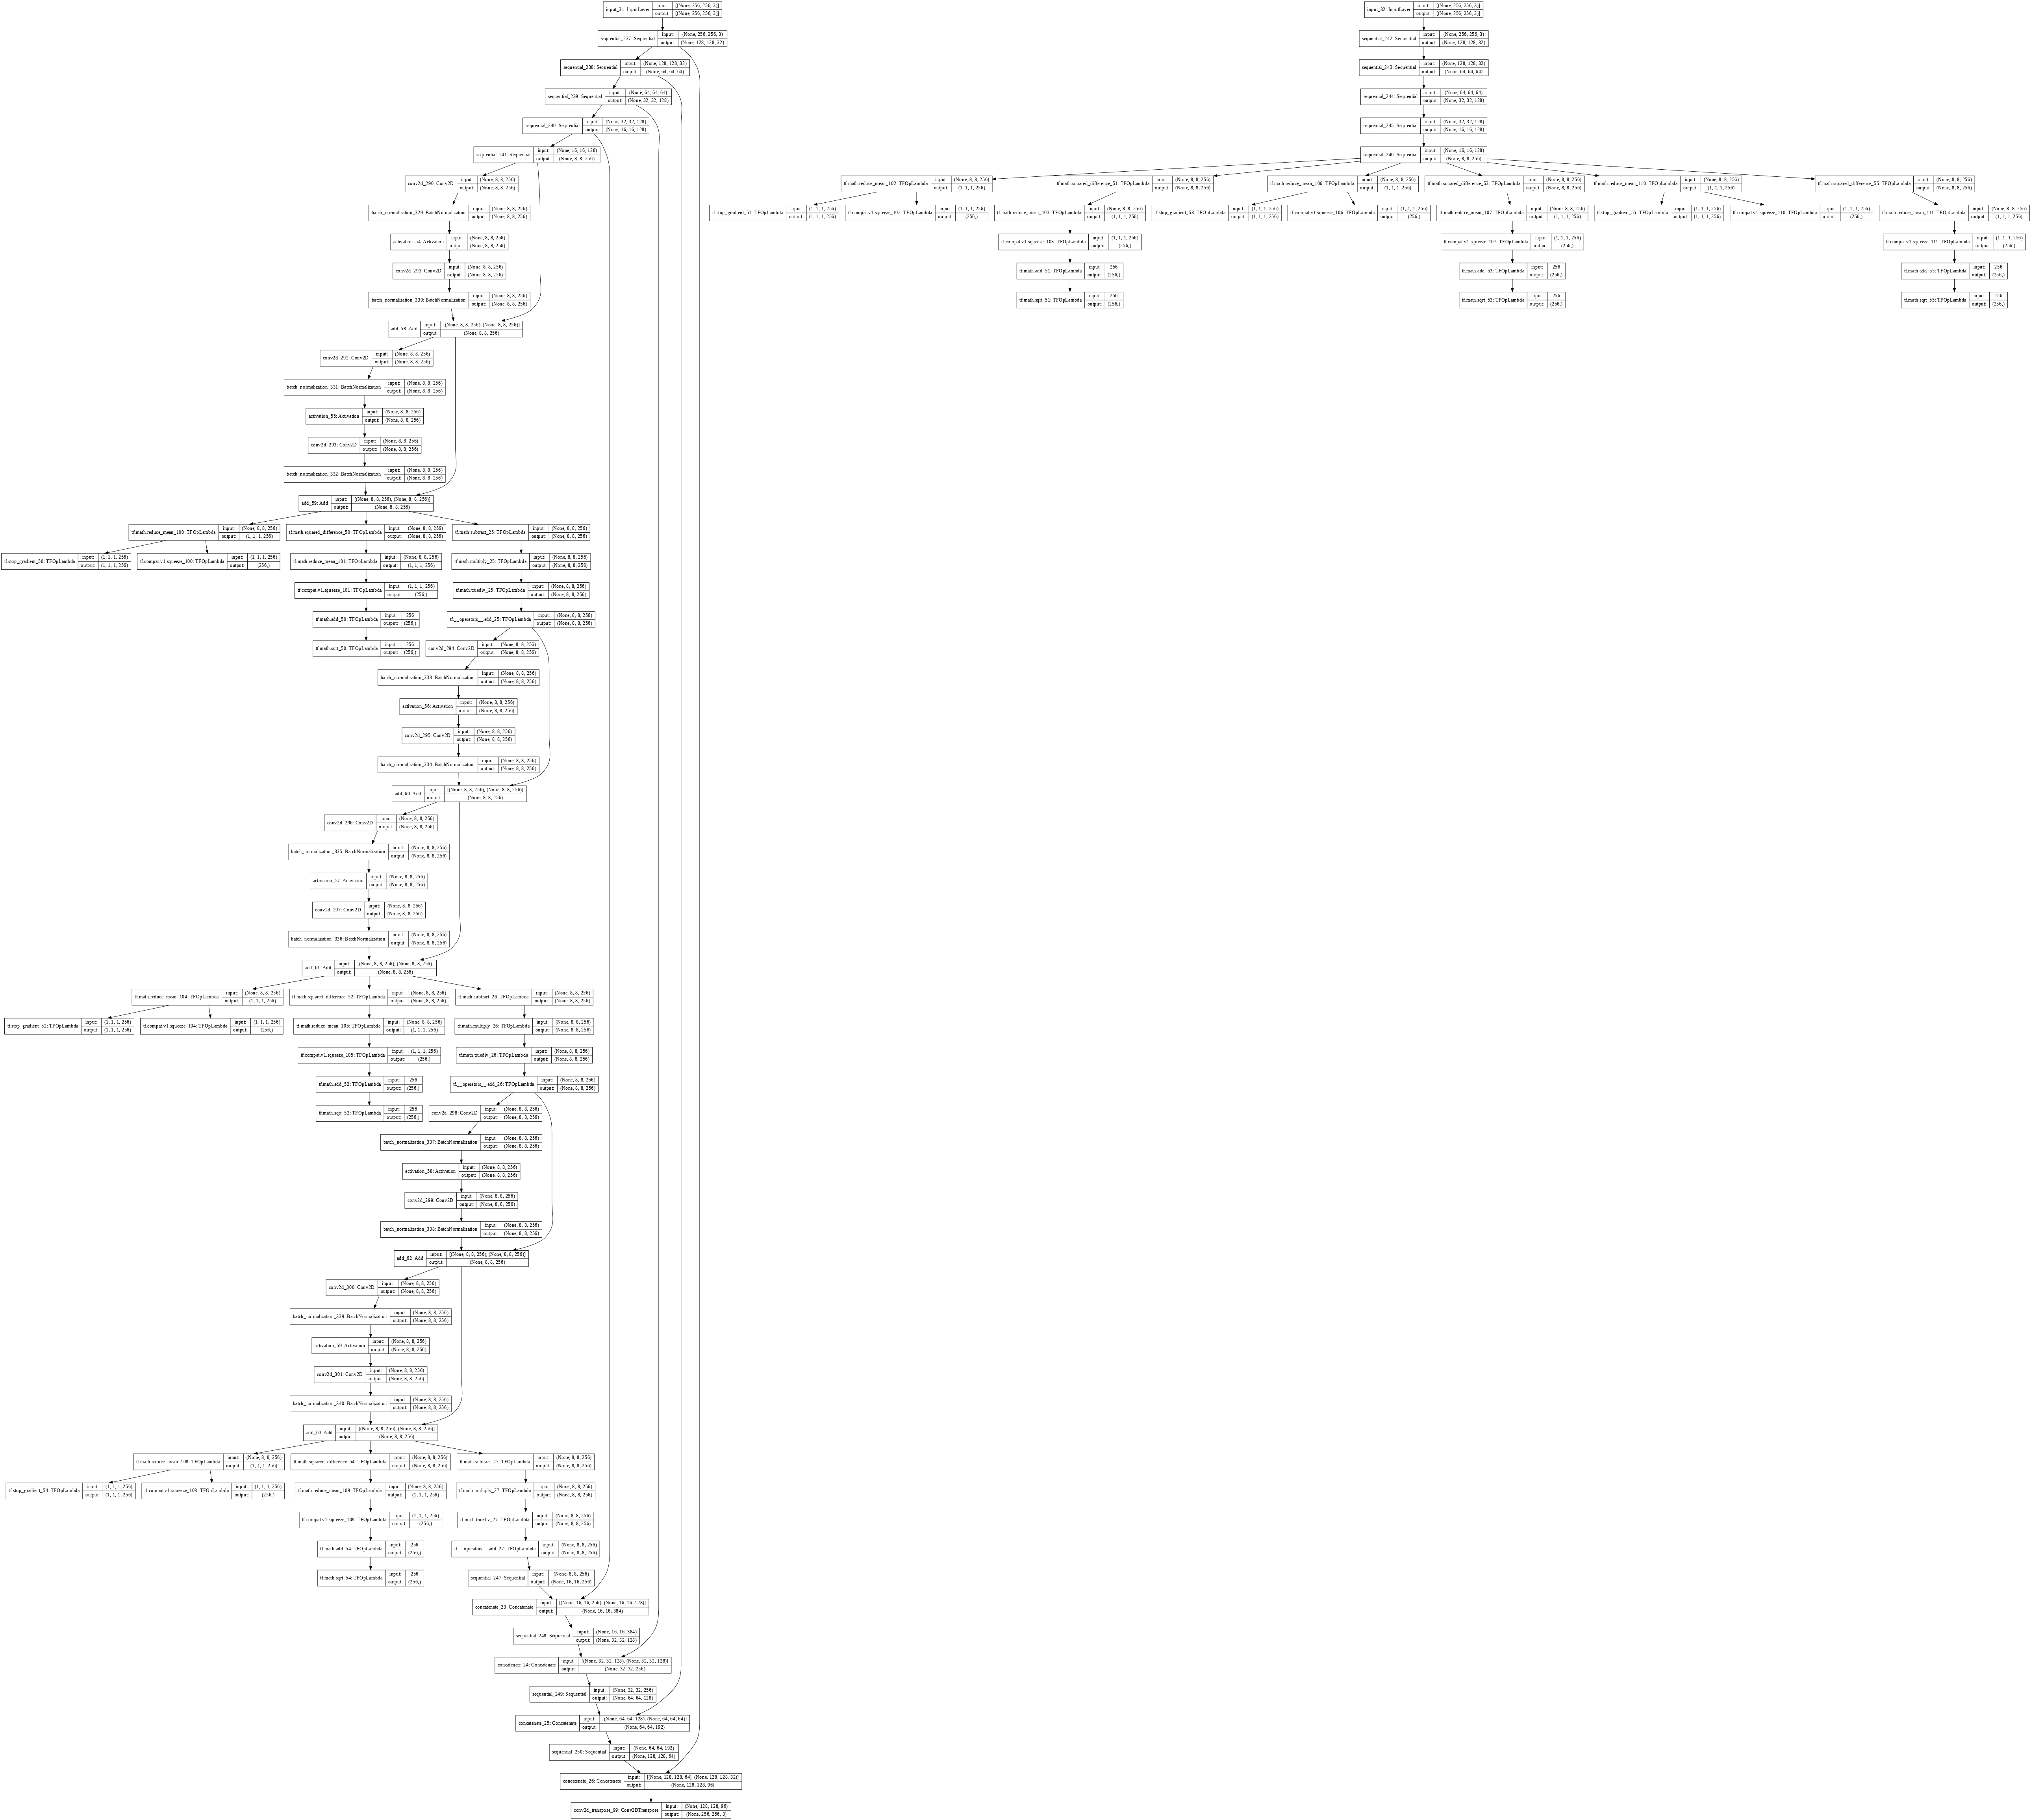

In [164]:
generator =Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [165]:
LAMBDA=100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [166]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.square(target - gen_output))  # reconstruction loss(Root mean square error)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [167]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar],axis=-1)  

  down1 = downsample(64, 4, False)(x) 
  down2 = downsample(128, 4)(down1)  
  down3 = downsample(256, 4)(down2)  

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) 

  return tf.keras.Model(inputs=[inp, tar], outputs=last)



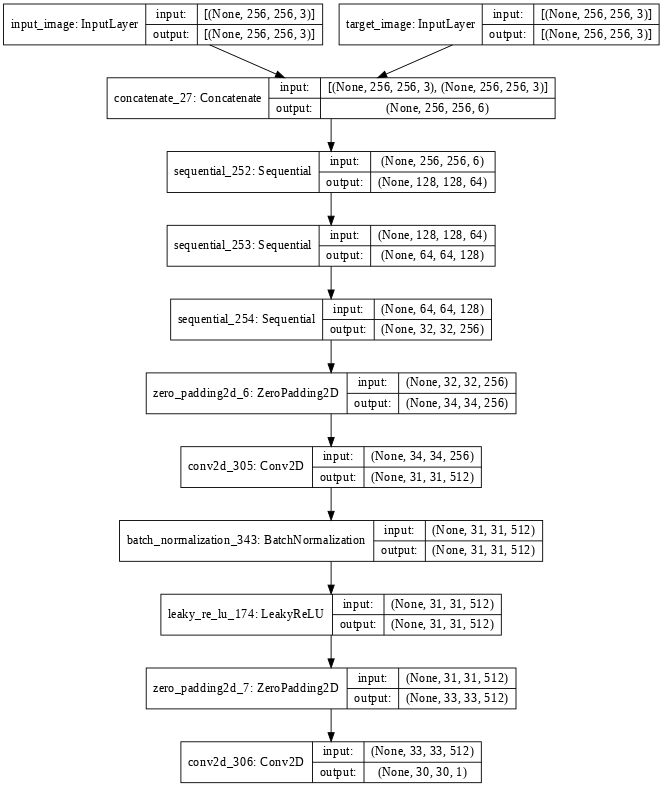

In [168]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [169]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [170]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [171]:
def generate_images(model,Target_image,Source_image):
  prediction = model([Target_image,Source_image])

  plt.figure(figsize=(12, 12))

  display_list = [Target_image[0], Source_image[0],prediction[0]]
  title = ['Target Image', 'Source image','Source Like Target Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [172]:
def train_step(Target_image,Source_image):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #print("r")
    gen_output = generator([Target_image,Source_image], training=True)
    #print("a")
    disc_real_output = discriminator([Target_image,Source_image], training=True)
    #print("m")
    disc_generated_output = discriminator([Target_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output,Target_image )
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  

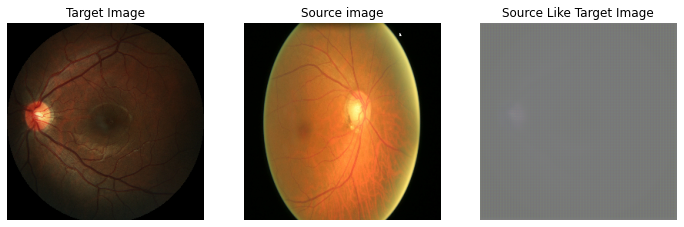

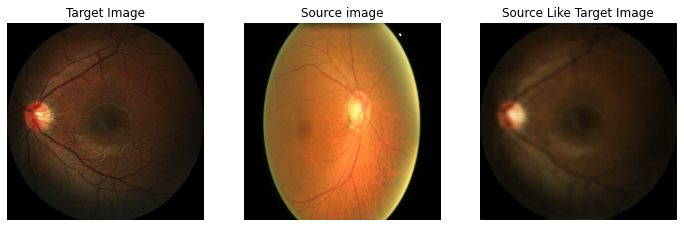

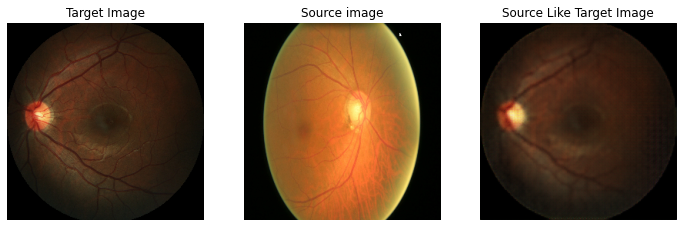

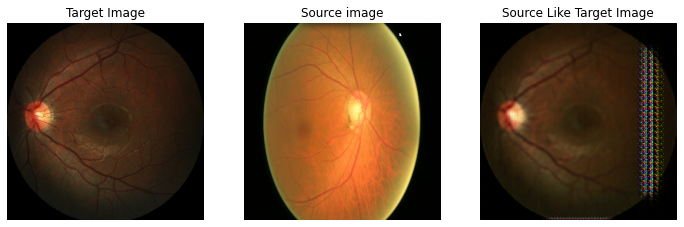

In [ ]:
for epoch in range(600):
  start = time.time()
  for image_x, image_y in tf.data.Dataset.zip((train_B, train_A)):
    #print(type(image_x))
    #print(type(image_y))
    train_step(image_x, image_y)
  if (epoch%50)==0:                         
    generate_images(generator,data_B,data_A)
  if (epoch%100)==0:
    generator.save('Generator.h5')
  #print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))


In [ ]:
data_testA = next(iter(test_A))
data_testB = next(iter(test_B))

In [ ]:
generator.summary()

In [ ]:
generator.save('Generator.h5')

In [ ]:
new_model = tf.keras.models.load_model('Generator.h5',compile=False)

In [ ]:
new_model.summary()

In [ ]:
data_testA =iter(test_A)
data_testB = iter(test_B)

In [ ]:
j=0
for i in test_A:
  j+=1
print(j)

In [ ]:
test_B.take(1)

In [ ]:
for i in test_A.take(20):
  for j in test_B.take(29):
    generate_images(new_model,i,j)